## Simulator Feature Wishlist:
 * Have the recommender weight unwatched videos higher + have users more willing to watch new videos
 * Give each user a baseline rating: to emulate how some users rate higher than others

## Potential Things to Look Into:
 * Perhaps have a more in-depth matrix of metadata for videos (e.g. vectors indicating authors / directors, run time, etc.)? This could potentially allow for more realistic viewing / recommendation schemes and also allow for more complex user simulated behaviors

In [1]:
%matplotlib inline
from __future__ import division
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
from scipy.sparse.linalg import svds
from IPython.display import display

## Setup

We have a matrix of films, such that each row is a vector holding the metadata for a film. Each film vector is organized as follows: [genre1, genre2, ..., genreN, quality], such that the first NUM_GENRES columns hold how aligned the film is with each genre, and the last column holds the film's quality, which dictates the mean rating for the film. The genre alignment values are all between 0 and 1, and sum to 1.

The user matrix is organized analogously, with each row holding the metdata for the user, in the format: [pref1, pref2, ..., prefN, behavior]. The NUM_GENRES columns hold how much a user likes a particular genre, and the last column holds the user's behavior, which determines how the user will react to recommended videos. Similarly, the preference values are all between 0 and 1, and sum to 1.

In [2]:
# Total number of film genres
NUM_GENRES = 2

# Maximum film rating (e.g. 5 uses the rating scale 0-5)
MAX_RATING = 5

# Higher values = stronger user genre preferences
# Use higher values with higher NUM_GENRES values
# Reasonable values are probably b/w 0.1 and 10
USER_POLARIZATION_STRENGTH = 1
FILM_POLARIZATION_STRENGTH = 1

# A user's "behavior" determines how a user chooses
# which video(s) to watch at each simulation step
# NAMES is a one-word description of each behavior,
# and DISTRIBUTION determines the ratio of behaviors
# among the created users
BEHAVIOR_PROP_IDX = NUM_GENRES
BEHAVIOR_NAMES = ['follower', 'stubborn', 'mixed']
BEHAVIOR_DISTRIBUTION = [1, 1, 1]

# If False, all users watch recommended films with
# probability equal to their compatibility with it
USE_BEHAVIOR = True

# A film's "quality" determines the mean rating
# of the film, and is used as the baseline which
# user preferences modify to get the final rating
QUALITY_PROP_IDX = NUM_GENRES
QUALITY_MIN = MAX_RATING / 4.0
QUALITY_MAX = 3 * MAX_RATING / 4.0

# If False, the average film rating is used as the
# baseline when calculating new ratings instead
USE_QUALITY = True

# Validate and standardize the behavior configuration parameters
if len(BEHAVIOR_NAMES) != len(BEHAVIOR_DISTRIBUTION):
    raise ValueError("BEHAVIOR_NAMES and BEHAVIOR_DISTRIBUTION "
            "must have the same length.")
BEHAVIOR_NAMES = np.array(BEHAVIOR_NAMES)
BEHAVIOR_DISTRIBUTION = np.array(BEHAVIOR_DISTRIBUTION) / float(sum(BEHAVIOR_DISTRIBUTION))

In [3]:
def generate_users(number_of_users):
    """
    Generate a user matrix, where each row of the
    matrix stores the properties of a user:
    [genre1_preference, ..., genreN_preference, behavior]
    
    The genre preferences of each user sum to 1.
    behavior will be an integer b/w 0 and num_behaviors
    """
    results = []
    for i in range(number_of_users):
        user_prefs = np.random.dirichlet(
                np.ones(NUM_GENRES)/USER_POLARIZATION_STRENGTH, size=1)[0]
        behavior = np.random.choice(np.arange(len(BEHAVIOR_NAMES)),
                p=BEHAVIOR_DISTRIBUTION)
        user_props = np.append(user_prefs, behavior)
        results.append(user_props)
    return np.array(results)

def generate_films(number_of_films):
    """
    Generate a film matrix, where each row of the
    matrix represents the properties of a film:
    [genre1, ..., genreN, quality]
    
    The genre values of each film sum to 1.
    quality will be b/w QUALITY_MIN and QUALITY_MAX.
    """
    results = []
    for i in range(number_of_films):
        film_genres = np.random.dirichlet(
                np.ones(NUM_GENRES)/FILM_POLARIZATION_STRENGTH, size=1)[0]
        quality = random.uniform(QUALITY_MIN, QUALITY_MAX)
        film_props = np.append(film_genres, quality)
        results.append(film_props)
    return np.array(results)

In [4]:
NUM_USERS = 6040 # 6040
NUM_FILMS = 3883 # 3883

users = generate_users(NUM_USERS)
films = generate_films(NUM_FILMS)

display(users)
print(users.shape)
display(films)
print(films.shape)

array([[0.75374284, 0.24625716, 2.        ],
       [0.19014584, 0.80985416, 2.        ],
       [0.71643622, 0.28356378, 2.        ],
       ...,
       [0.88205683, 0.11794317, 0.        ],
       [0.56658095, 0.43341905, 0.        ],
       [0.03508985, 0.96491015, 0.        ]])

(6040, 3)


array([[0.41258386, 0.58741614, 2.30898681],
       [0.80207487, 0.19792513, 2.86090031],
       [0.18011447, 0.81988553, 2.1424596 ],
       ...,
       [0.49827837, 0.50172163, 2.53225739],
       [0.92405247, 0.07594753, 1.31955861],
       [0.36430479, 0.63569521, 2.03855592]])

(3883, 3)


In [5]:
def get_user_film_compatibility(userID, filmID):
    """
    Returns a value between 0 and 1 indicating how much
    a user's preferences aligns with the film's genre(s).
    """
    user_prefs = users[userID][:NUM_GENRES]
    film_genres = films[filmID][:NUM_GENRES]
    return 1 - (np.sum(np.abs(user_prefs - film_genres)) / NUM_GENRES)

# Compute the compatabilities of a random sample of users
# and films, so some stats can be calcuated on them
compats = []
sample_userIDs = random.sample(np.arange(NUM_USERS), min(500, NUM_USERS))
sample_filmIDs = random.sample(np.arange(NUM_FILMS), min(500, NUM_FILMS))
for userID in sample_userIDs:
    for filmID in sample_filmIDs:
        compats.append(get_user_film_compatibility(userID, filmID))

mean_compatibility = 1.0 * sum(compats) / len(compats)
max_abs_compatibility = max(max(compats), abs(min(compats)))

print("Mean compatibility: %f" % mean_compatibility)
print("Max absolute compatibility: %f" % max_abs_compatibility)

Mean compatibility: 0.668527
Max absolute compatibility: 0.999998


In [6]:
# Determines how much a user's compatibility with 
# the film affects the final rating. The final
# rating given will be mean_film_rating + x,
# where -CRS <= x <= CRS
COMPATIBILITY_RATING_STRENGTH = 3

def get_user_film_rating(userID, filmID, actual_ratings=None, is_initial_rating=False):
    """
    Returns a value between 0 and MAX_RATING indicating the
    rating the user would give the film upon watching it.
    
    actual_ratings must be provided when USE_QUALITY and
    is_initial_rating is False, so the current mean rating
    of the film can be calculated.
    
    is_initial_rating should be set True when generating the
    starting ratings for the film.
    """
    compatibility = get_user_film_compatibility(userID, filmID)
    
    if USE_QUALITY:
        base_rating = films[filmID][QUALITY_PROP_IDX]
    else:
        if is_initial_rating:
            return round(MAX_RATING * compatibility)
        else:
            film_ratings = actual_ratings[:, filmID]
            base_rating = np.mean(film_ratings[film_ratings.nonzero()])

    # Convert compatibility to a value within [-CRS, +CRS]
    compat_influence = ((compatibility - mean_compatibility)
            / max_abs_compatibility) * COMPATIBILITY_RATING_STRENGTH
    return max(min(round(base_rating + compat_influence), MAX_RATING), 0)

def generate_initial_ratings(users, films, view_rate, rescale_to_midline=False):
    """
    Generates a (num_films, num_users) rating matrix, where
    each row represents the ratings that film has received
    from all users.
    
    view_rate is the chance a user will view a given film.
    
    If rescale_to_midline is True, the ratings are scaled
    such that mean of non-zero ratings is MAX_RATING / 2.
    """
    results = []
    for filmID in range(films.shape[0]):
        film_ratings = []
        for userID in range(users.shape[0]):
            ran = random.uniform(0,1)
            if (ran <= view_rate):
                rating = get_user_film_rating(userID, filmID, is_initial_rating=True)
                film_ratings.append(rating)
            else:
                film_ratings.append(0)
        results.append(film_ratings)
    results = np.array(results)
    # Perform rescaling if necessary
    if rescale_to_midline:
        results = results * ((MAX_RATING / 2.0) / (results[results.nonzero()].mean()))
        results = np.clip(np.round(results), 0, MAX_RATING)
    return results

In [7]:
INITIAL_VIEWING_RATE = 0.05 # 0.05
RESCALE_TO_MIDLINE = True

initial_ratings = generate_initial_ratings(users, films,
        INITIAL_VIEWING_RATE, rescale_to_midline=RESCALE_TO_MIDLINE)

display(initial_ratings)
print(initial_ratings.shape)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

(3883, 6040)


In [8]:
# The number of singular values to compute with SVD
# Larger values give more accurate predictions, but
# take longer to compute (and give longer simulator
# convergence times)
# Reasonable values are probably b/w 10 and 50
K_VAL = 50

def get_predicted_ratings(actual_ratings):
    """
    Returns a (num_users, num_films) matrix containing
    the predicted ratings each user would each film.
    """
    # Only consider non-zero ratings when calculating the mean
    masked_user_ratings = np.ma.masked_equal(initial_ratings.T, 0)
    user_ratings_mean = masked_user_ratings.mean(axis=1).data
    # Calculate SVD values of demeaned ratings + estimate new ratings
    R_demeaned = actual_ratings.T - user_ratings_mean.reshape(-1, 1)
    U, sigma, Vt = svds(R_demeaned, k=K_VAL)
    sigma = np.diag(sigma)
    predicted_ratings = np.round(np.dot(np.dot(U, sigma), Vt) +
            user_ratings_mean.reshape(-1, 1))
    return predicted_ratings

example_predictions = get_predicted_ratings(initial_ratings)
display(example_predictions)
print(example_predictions.shape)

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0., -0.,  0.],
       [ 0.,  0.,  0., ..., -0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ..., -0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0., -0.,  0.]])

(6040, 3883)


In [9]:
NUM_RECS = 5

def get_recommendations(predicted_ratings, userID, num_recommendations=NUM_RECS):
    """
    Gets the top num_recommendations film recommendations for
    the provided user, using the rating prediction matrix, and
    returns a tuple containing the recommended film IDs, and
    counts of the recommendations received of each film genre.
    """
    predicted_user_ratings = predicted_ratings[userID]
    recommended_filmIDs = np.argsort(predicted_user_ratings)\
            [-num_recommendations:].tolist()
    film_recs = films[recommended_filmIDs, :]
    genre_counts = [int(round(sum(film_recs[:, genre_idx])))
                    for genre_idx in range(NUM_GENRES)]
    return (recommended_filmIDs, genre_counts)

example_recs = get_recommendations(example_predictions, 0)
print("Example Film Recommendations: " + str(example_recs[0]))
print("Example Distribution: " + str(example_recs[1]))

Example Film Recommendations: [900, 2341, 2111, 67, 2173]
Example Distribution: [3, 2]


In [10]:
# Probability of a follower watching a recommended film
FOLLOWER_VIEW_RATE = 0.5

# Minimum compatibility a stubborn user must
# have with a film in order to watch it
STUBBORN_COMPATIBILITY_THRESHOLD = 0.8

def give_recommendation(userID, filmID, actual_ratings):
    """
    Actually gives a film recommendation to a user, and
    determines whether the user will watch it, based on
    their behavior, and returns the rating if so.
    Returns None if the user does not watch the film.
    """
    behavior_name = BEHAVIOR_NAMES[int(users[userID][BEHAVIOR_PROP_IDX])]
    compatibility = get_user_film_compatibility(userID, filmID)
    ran = random.uniform(0, 1)
    
    # Follower: watches any of the recommended films with equal weight 
    if behavior_name == "follower":
        watched = ran <= FOLLOWER_VIEW_RATE
    # Mixed: watches a recommended video with probability
    # equal to their compatability with that film
    elif behavior_name == "mixed":
        watched = ran <= compatibility
    # Stubborn: only watches videos above a certain compatibility threshold
    elif behavior_name == "stubborn":
        watched = compatibility <= STUBBORN_COMPATIBILITY_THRESHOLD
    else:
        raise ValueError("Programmer Error: Unexpected behavior value '%d'" % behavior)
        
    if watched:
        return get_user_film_rating(userID, filmID, actual_ratings)
    else:
        return None

In [11]:
# number of neutral users
neutral = 0

# number of polarized films
polarity = 0

# thresholds for neutral user preference
lo_threshold = 0.3
hi_threshold = 0.7

for userIdx in range(users.shape[0]):
    if lo_threshold < users[userIdx][0] < hi_threshold and lo_threshold < users[userIdx][1] < hi_threshold:
        neutral += 1
        movie_recs, movie_dist = get_recommendations(example_predictions, userIdx)
        if movie_dist != [2, 3] and movie_dist != [3, 2]:
            polarity += 1

print("Number of users with neutral preference: " + str(neutral))
print("Number of polarized films recommended to those users: " + str(polarity))
print("Polarity: " + str(polarity/neutral))

Number of users with neutral preference: 2383
Number of polarized films recommended to those users: 83
Polarity: 0.0348300461603


## Run Simulator

In [12]:
initial_predictions = get_predicted_ratings(initial_ratings)

# A (num_users, num_genres) matrix where each row
# is the number of recommendations that user has
# received of each film genre
initial_distribution_matrix = []

# Get the initial recommendation genre distribution
for userID in range(users.shape[0]):
    (recommended_filmIDs, type_counts) = get_recommendations(initial_predictions, userID)
    initial_distribution_matrix.append(type_counts)

display(initial_distribution_matrix[:10])

[[3, 2],
 [2, 3],
 [2, 3],
 [3, 2],
 [3, 2],
 [3, 2],
 [2, 3],
 [3, 2],
 [3, 2],
 [2, 3]]

In [13]:
def step_simulation(actual_ratings, predicted_ratings,
                    rec_genre_counts, verbose=False):
    """
    Runs one step of the simulation:
    
    Gives new recommendations to each user, and simulates them
    viewing + rating a random selection of them.
    
    Returns the new rating matrix, the new distribution matrix of
    recommended film genres, and the # of changes in this matrix.
    
    If verbose is True, prints extra debugging information.
    """
    new_ratings = actual_ratings.copy()
    new_distribution_matrix = []
    num_distribution_changes = 0
    
    for userID in range(users.shape[0]):
        user = users[userID]
        (recommended_filmIDs, new_genre_counts) = \
                get_recommendations(predicted_ratings, userID)
        new_distribution_matrix.append(new_genre_counts)
        
        # Check for changes in the user's recommendation distribution
        if (new_genre_counts[0] != rec_genre_counts[userID][0]) or \
                (new_genre_counts[1] != rec_genre_counts[userID][1]):
            num_distribution_changes += 1
        
        # Determine whether the user will watch each
        # recommended film, and assign a rating if so
        for filmID in recommended_filmIDs:
            rating = None
            if USE_BEHAVIOR:
                rating = give_recommendation(userID, filmID, actual_ratings)
            else:
                compatibility = get_user_film_compatibility(userID, filmID)
                ran = random.uniform(0,1)
                if ran <= compatibility:
                    rating = get_user_film_rating(userID, filmID, actual_ratings)
            if rating is not None:
                new_ratings[filmID, userID] = rating

    return (new_ratings, new_distribution_matrix, num_distribution_changes)

In [14]:
MAX_STEPS = 500
CHANGE_THRESHOLD = 0
VERBOSE = False

ratings = initial_ratings.copy()
predictions = initial_predictions.copy()
rec_distribution = list(initial_distribution_matrix)
num_changes_over_time = []

for step in range(MAX_STEPS):
    predictions = get_predicted_ratings(ratings)
    ratings, rec_distribution, num_changes = step_simulation(ratings,
            predictions, rec_distribution, verbose=VERBOSE)
    num_changes_over_time.append(num_changes)
    if step > 0 and num_changes <= CHANGE_THRESHOLD:
        print("Convergence!")
        break
    print("Step #%d: Num Changes = %d" % (step, num_changes))

Step #0: Num Changes = 0
Step #1: Num Changes = 2414
Step #2: Num Changes = 2099
Step #3: Num Changes = 1781
Step #4: Num Changes = 1412
Step #5: Num Changes = 1211
Step #6: Num Changes = 1035
Step #7: Num Changes = 950
Step #8: Num Changes = 878
Step #9: Num Changes = 827
Step #10: Num Changes = 783
Step #11: Num Changes = 771
Step #12: Num Changes = 721
Step #13: Num Changes = 697
Step #14: Num Changes = 692
Step #15: Num Changes = 669
Step #16: Num Changes = 644
Step #17: Num Changes = 602
Step #18: Num Changes = 598
Step #19: Num Changes = 583
Step #20: Num Changes = 565
Step #21: Num Changes = 579
Step #22: Num Changes = 521
Step #23: Num Changes = 471
Step #24: Num Changes = 507
Step #25: Num Changes = 505
Step #26: Num Changes = 470
Step #27: Num Changes = 498
Step #28: Num Changes = 485
Step #29: Num Changes = 442
Step #30: Num Changes = 421
Step #31: Num Changes = 459
Step #32: Num Changes = 415
Step #33: Num Changes = 418
Step #34: Num Changes = 365
Step #35: Num Changes = 37

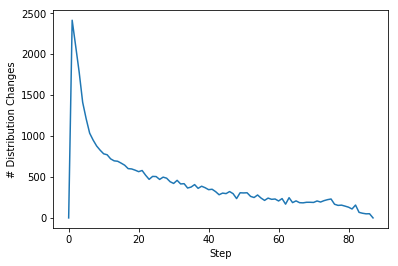

In [15]:
# Plot the recommendation distribution changes over time
plt.plot(num_changes_over_time)
plt.xlabel("Step")
plt.ylabel("# Distribution Changes")
plt.show()

### Observations:
Note that the higher the `COMPATIBILITY_RATING_STRENGTH`, the greater the difference between the average rating and the film quality, as expected. In general, the average rating should be higher than the film quality, because films will be recommended to users that the algorithm predicts will like it. An average rating that is lower the film quality suggests that the recommender made poor decisions when recommending that film to users.

Also note that higher quality films have more ratings, as they are recommended to more people.

In [16]:
def display_ratings_stats(filmID):
    film_quality = films[filmID][QUALITY_PROP_IDX]
    film_ratings = ratings[filmID]
    film_ratings = film_ratings[film_ratings.nonzero()]
    print("Film Matrix: " + str(films[filmID]))
    print("Film Quality: " + str(film_quality))
    print("Average Rating: " + str(film_ratings.mean()))
    display(film_ratings)

# Print some stats about the film ratings
mean_ratings = np.true_divide(ratings.sum(1),(ratings!=0).sum(1))
print("Sample Film\n-----------\n")
display_ratings_stats(0)
print("\n\nHighest Rated Film\n------------------\n")
display_ratings_stats(np.argmax(mean_ratings))
print("\nLowest Rated Film\n-----------------\n")
display_ratings_stats(np.argmin(mean_ratings))

Sample Film
-----------

Film Matrix: [0.41258386 0.58741614 2.30898681]
Film Quality: 2.3089868136695038
Average Rating: 2.466898954703833


array([2., 2., 3., 2., 3., 3., 3., 2., 2., 3., 2., 3., 2., 3., 2., 2., 2.,
       3., 2., 2., 2., 3., 3., 3., 2., 3., 2., 2., 3., 3., 2., 3., 2., 3.,
       3., 2., 3., 3., 3., 3., 3., 2., 2., 3., 2., 2., 3., 2., 3., 2., 3.,
       2., 3., 2., 3., 3., 2., 3., 2., 3., 2., 3., 3., 2., 3., 3., 2., 2.,
       3., 3., 3., 2., 3., 3., 2., 2., 3., 2., 2., 3., 3., 2., 2., 2., 2.,
       3., 3., 2., 2., 3., 3., 2., 3., 2., 2., 2., 2., 2., 2., 3., 3., 3.,
       3., 3., 3., 2., 3., 2., 2., 3., 2., 2., 3., 2., 2., 2., 2., 3., 2.,
       2., 3., 3., 2., 2., 2., 2., 2., 3., 2., 2., 2., 2., 2., 3., 3., 2.,
       2., 3., 3., 3., 2., 3., 2., 3., 3., 3., 3., 2., 3., 3., 2., 3., 2.,
       2., 2., 2., 3., 2., 3., 2., 3., 2., 2., 3., 2., 3., 2., 2., 2., 2.,
       3., 2., 3., 2., 3., 2., 2., 3., 3., 2., 2., 3., 3., 3., 3., 3., 3.,
       2., 2., 2., 2., 3., 2., 2., 3., 3., 2., 3., 3., 3., 3., 2., 2., 3.,
       3., 2., 2., 3., 2., 2., 3., 3., 2., 3., 3., 2., 3., 3., 2., 2., 2.,
       2., 2., 2., 2., 3.



Highest Rated Film
------------------

Film Matrix: [0.6563961  0.3436039  3.74308092]
Film Quality: 3.743080920725827
Average Rating: 3.9767827529021558


array([4., 3., 3., 4., 5., 5., 4., 4., 3., 4., 4., 4., 3., 4., 4., 4., 4.,
       5., 3., 5., 4., 5., 5., 4., 3., 3., 3., 5., 4., 5., 3., 3., 3., 4.,
       4., 3., 5., 4., 4., 3., 4., 5., 5., 4., 4., 5., 4., 4., 3., 3., 4.,
       3., 4., 4., 4., 4., 3., 4., 4., 3., 4., 4., 4., 4., 4., 4., 4., 5.,
       4., 4., 4., 5., 4., 3., 3., 3., 4., 5., 3., 3., 5., 4., 3., 5., 4.,
       4., 5., 4., 4., 4., 5., 4., 4., 5., 4., 4., 4., 4., 4., 4., 4., 4.,
       5., 4., 4., 4., 5., 4., 4., 4., 4., 3., 3., 3., 3., 3., 5., 5., 5.,
       5., 4., 3., 4., 5., 4., 5., 4., 4., 4., 4., 4., 3., 4., 4., 4., 4.,
       4., 4., 4., 3., 4., 4., 4., 4., 4., 5., 4., 4., 4., 4., 4., 4., 5.,
       3., 5., 4., 4., 4., 4., 4., 5., 4., 5., 4., 4., 4., 4., 4., 4., 5.,
       3., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 5., 3., 4., 3., 4., 4.,
       5., 4., 4., 4., 4., 4., 4., 4., 3., 4., 4., 3., 4., 4., 3., 5., 5.,
       5., 3., 5., 5., 5., 4., 4., 4., 5., 3., 3., 4., 4., 5., 5., 4., 5.,
       4., 3., 4., 4., 4.


Lowest Rated Film
-----------------

Film Matrix: [0.00979107 0.99020893 1.29886877]
Film Quality: 1.2988687664386473
Average Rating: 1.3988095238095237


array([1., 2., 2., 1., 1., 2., 1., 1., 1., 1., 2., 1., 1., 2., 1., 2., 2.,
       2., 2., 2., 1., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 1., 1., 1.,
       1., 1., 2., 1., 1., 2., 1., 2., 1., 1., 1., 1., 1., 1., 1., 2., 1.,
       1., 1., 2., 1., 1., 1., 2., 1., 1., 2., 2., 2., 1., 2., 2., 1., 1.,
       1., 2., 1., 2., 1., 2., 1., 1., 2., 1., 1., 1., 1., 2., 1., 1., 2.,
       1., 1., 1., 1., 1., 2., 1., 1., 1., 1., 2., 2., 1., 1., 2., 2., 1.,
       2., 2., 2., 1., 1., 2., 1., 1., 2., 2., 1., 2., 1., 1., 2., 2., 1.,
       1., 2., 1., 2., 1., 1., 2., 2., 2., 1., 1., 1., 1., 1., 1., 2., 1.,
       1., 1., 2., 2., 1., 1., 2., 2., 1., 2., 1., 1., 1., 1., 1., 1., 1.,
       2., 1., 1., 1., 1., 1., 2., 1., 1., 1., 2., 1., 2., 2., 1.])

In [17]:
sorted_movies = np.argsort(-mean_ratings)

for i in range(10):
    display_ratings_stats(sorted_movies[i])

Film Matrix: [0.6563961  0.3436039  3.74308092]
Film Quality: 3.743080920725827
Average Rating: 3.9767827529021558


array([4., 3., 3., 4., 5., 5., 4., 4., 3., 4., 4., 4., 3., 4., 4., 4., 4.,
       5., 3., 5., 4., 5., 5., 4., 3., 3., 3., 5., 4., 5., 3., 3., 3., 4.,
       4., 3., 5., 4., 4., 3., 4., 5., 5., 4., 4., 5., 4., 4., 3., 3., 4.,
       3., 4., 4., 4., 4., 3., 4., 4., 3., 4., 4., 4., 4., 4., 4., 4., 5.,
       4., 4., 4., 5., 4., 3., 3., 3., 4., 5., 3., 3., 5., 4., 3., 5., 4.,
       4., 5., 4., 4., 4., 5., 4., 4., 5., 4., 4., 4., 4., 4., 4., 4., 4.,
       5., 4., 4., 4., 5., 4., 4., 4., 4., 3., 3., 3., 3., 3., 5., 5., 5.,
       5., 4., 3., 4., 5., 4., 5., 4., 4., 4., 4., 4., 3., 4., 4., 4., 4.,
       4., 4., 4., 3., 4., 4., 4., 4., 4., 5., 4., 4., 4., 4., 4., 4., 5.,
       3., 5., 4., 4., 4., 4., 4., 5., 4., 5., 4., 4., 4., 4., 4., 4., 5.,
       3., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 5., 3., 4., 3., 4., 4.,
       5., 4., 4., 4., 4., 4., 4., 4., 3., 4., 4., 3., 4., 4., 3., 5., 5.,
       5., 3., 5., 5., 5., 4., 4., 4., 5., 3., 3., 4., 4., 5., 5., 4., 5.,
       4., 3., 4., 4., 4.

Film Matrix: [0.41529622 0.58470378 3.71592079]
Film Quality: 3.715920793966276
Average Rating: 3.9705882352941178


array([4., 4., 4., 3., 4., 3., 4., 4., 5., 4., 5., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 3., 5., 4., 4., 4., 4., 4., 5., 4., 4., 4., 5., 4.,
       4., 4., 4., 4., 4., 4., 5., 4., 4., 4., 3., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 5., 4., 4., 4., 4., 3., 3., 3., 3., 3., 4., 4.,
       4., 5., 4., 4., 4., 4., 4., 5., 3., 4., 4., 3., 4., 5., 4., 4., 4.,
       5., 3., 4., 3., 4., 4., 5., 4., 4., 3., 3., 4., 5., 4., 4., 4., 4.,
       5., 4., 3., 4., 4., 4., 4., 3., 4., 3., 4., 4., 3., 4., 4., 5., 4.,
       5., 4., 4., 4., 5., 4., 4., 3., 4., 3., 3., 4., 5., 4., 4., 3., 5.,
       3., 4., 4., 4., 4., 5., 4., 4., 4., 4., 4., 5., 4., 4., 3., 4., 3.,
       4., 5., 4., 4., 4., 4., 4., 4., 5., 4., 4., 5., 4., 4., 3., 4., 3.,
       5., 5., 4., 3., 5., 4., 5., 4., 3., 3., 5., 4., 4., 3., 4., 3., 4.,
       5., 4., 5., 3., 4., 5., 4., 3., 4., 4., 5., 4., 4., 3., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 3., 4., 3., 4., 3., 4., 4., 4., 3., 4.,
       3., 4., 4., 5., 4.

Film Matrix: [0.46110599 0.53889401 3.7174499 ]
Film Quality: 3.717449904860726
Average Rating: 3.9594356261022927


array([4., 4., 4., 3., 5., 3., 3., 4., 5., 3., 4., 3., 4., 3., 3., 4., 4.,
       4., 4., 4., 3., 4., 4., 3., 5., 5., 4., 4., 4., 4., 5., 4., 4., 5.,
       4., 4., 4., 4., 5., 5., 4., 5., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 3., 4., 4., 5., 4., 4., 4., 4., 4., 4., 4., 3., 4., 3., 4., 3.,
       4., 4., 4., 4., 3., 5., 4., 4., 5., 3., 5., 3., 4., 4., 3., 4., 4.,
       4., 5., 4., 4., 4., 4., 3., 4., 4., 4., 4., 4., 4., 4., 3., 3., 4.,
       4., 4., 5., 4., 4., 5., 4., 4., 4., 5., 4., 3., 4., 4., 4., 4., 4.,
       5., 3., 5., 4., 3., 5., 4., 4., 4., 5., 4., 4., 4., 3., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 3., 4., 5., 4., 3., 4., 4., 4., 4., 3.,
       4., 4., 4., 4., 3., 4., 3., 4., 4., 4., 4., 4., 4., 4., 4., 4., 3.,
       4., 4., 4., 4., 3., 4., 4., 4., 4., 3., 3., 5., 4., 3., 3., 5., 3.,
       3., 5., 4., 4., 3., 3., 5., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 3., 4., 4., 4., 4., 3., 4., 4., 4., 3., 4., 4., 3.,
       4., 3., 4., 4., 4.

Film Matrix: [0.42750099 0.57249901 3.7485562 ]
Film Quality: 3.7485562007080104
Average Rating: 3.9537892791127542


array([4., 3., 4., 4., 3., 4., 3., 3., 4., 3., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 3., 3., 3., 4., 4., 3., 4., 4., 4., 4., 4., 3., 4., 4.,
       4., 5., 4., 3., 4., 3., 4., 5., 4., 4., 4., 4., 4., 5., 4., 5., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 3., 4., 4., 4., 4., 5., 5., 4.,
       4., 4., 5., 4., 4., 5., 4., 4., 3., 3., 4., 4., 5., 4., 4., 4., 4.,
       4., 4., 5., 4., 4., 4., 3., 5., 4., 4., 4., 4., 4., 3., 5., 4., 4.,
       4., 4., 3., 4., 4., 4., 4., 4., 5., 5., 4., 4., 5., 4., 5., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 3., 4., 4., 5., 4., 5., 5., 4., 4.,
       4., 4., 3., 4., 4., 4., 3., 4., 3., 4., 4., 5., 4., 4., 3., 3., 4.,
       4., 5., 3., 4., 4., 3., 5., 5., 4., 3., 3., 3., 4., 5., 4., 4., 4.,
       4., 3., 4., 5., 4., 5., 4., 4., 4., 4., 4., 4., 4., 4., 4., 3., 4.,
       5., 5., 3., 4., 3., 4., 3., 4., 3., 4., 5., 4., 4., 4., 4., 4., 4.,
       5., 5., 3., 3., 3., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 5., 3.

Film Matrix: [0.56423388 0.43576612 3.70775351]
Film Quality: 3.7077535111436752
Average Rating: 3.9439775910364148


array([4., 4., 4., 4., 4., 4., 5., 4., 3., 4., 3., 5., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 3., 4., 4., 4., 3., 4., 4., 5., 4., 4., 4., 4., 4.,
       4., 4., 4., 5., 5., 3., 4., 4., 4., 3., 4., 3., 4., 5., 5., 4., 5.,
       3., 5., 4., 4., 4., 4., 4., 3., 4., 4., 5., 4., 3., 5., 4., 3., 4.,
       3., 4., 3., 4., 5., 5., 4., 4., 4., 5., 3., 4., 4., 5., 4., 4., 4.,
       4., 5., 4., 3., 3., 4., 5., 3., 4., 4., 4., 4., 3., 4., 4., 5., 4.,
       4., 4., 3., 3., 4., 4., 4., 3., 5., 4., 5., 3., 4., 4., 5., 3., 4.,
       4., 3., 3., 4., 3., 4., 5., 5., 4., 4., 5., 3., 3., 5., 4., 5., 4.,
       5., 4., 4., 5., 4., 3., 3., 4., 4., 4., 4., 3., 4., 4., 4., 3., 3.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 5., 4., 3., 4., 4., 4., 4.,
       5., 4., 4., 4., 4., 4., 3., 3., 4., 4., 4., 3., 3., 4., 4., 5., 3.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 5., 3., 4., 4., 4., 5., 4., 4.,
       4., 3., 5., 4., 4., 4., 4., 4., 3., 4., 4., 4., 3., 4., 4., 4., 4.,
       3., 4., 4., 5., 4.

Film Matrix: [0.37272697 0.62727303 3.72856326]
Film Quality: 3.728563257517659
Average Rating: 3.9403846153846156


array([5., 4., 3., 4., 3., 5., 4., 4., 3., 4., 4., 5., 5., 4., 3., 4., 4.,
       4., 4., 4., 4., 3., 4., 3., 4., 5., 3., 4., 4., 5., 4., 4., 5., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 5., 4., 4., 5., 4., 3., 4., 4., 5.,
       4., 3., 4., 4., 4., 4., 5., 4., 4., 4., 4., 3., 4., 4., 3., 4., 3.,
       3., 4., 3., 4., 3., 3., 4., 4., 4., 4., 4., 4., 4., 4., 5., 4., 4.,
       4., 4., 4., 4., 3., 4., 4., 3., 3., 4., 3., 4., 4., 4., 4., 4., 3.,
       4., 5., 5., 5., 5., 5., 3., 3., 4., 4., 4., 5., 4., 4., 4., 4., 4.,
       4., 4., 5., 4., 3., 4., 5., 4., 4., 5., 4., 4., 4., 4., 3., 4., 4.,
       3., 5., 4., 4., 3., 4., 4., 4., 5., 3., 3., 4., 4., 4., 4., 4., 5.,
       4., 4., 4., 3., 4., 4., 4., 4., 4., 4., 4., 4., 4., 3., 4., 4., 3.,
       4., 5., 3., 3., 4., 4., 5., 4., 5., 4., 5., 4., 4., 3., 4., 4., 3.,
       4., 4., 4., 4., 4., 5., 4., 4., 4., 4., 4., 4., 4., 3., 4., 4., 4.,
       3., 3., 4., 4., 4., 3., 4., 4., 4., 5., 3., 4., 4., 5., 4., 4., 4.,
       5., 3., 4., 4., 3.

Film Matrix: [0.40714499 0.59285501 3.73824934]
Film Quality: 3.738249339630466
Average Rating: 3.9378330373001775


array([3., 4., 4., 3., 4., 4., 4., 4., 4., 4., 4., 5., 5., 3., 4., 4., 4.,
       4., 4., 4., 3., 4., 5., 4., 3., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 5., 5., 4., 4., 4., 4., 3., 5., 3., 4., 5., 4., 3.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 5., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 3., 4., 5., 4., 4., 4., 4., 4., 4., 4., 4., 4., 3.,
       4., 5., 4., 4., 4., 4., 4., 4., 4., 4., 3., 4., 4., 4., 4., 4., 4.,
       5., 3., 5., 5., 4., 4., 3., 4., 4., 5., 4., 4., 3., 3., 4., 4., 4.,
       4., 4., 4., 4., 5., 4., 3., 4., 4., 4., 3., 4., 3., 4., 4., 4., 4.,
       5., 4., 4., 5., 4., 3., 4., 4., 5., 3., 4., 3., 3., 4., 4., 4., 5.,
       4., 3., 5., 5., 4., 3., 4., 3., 4., 3., 4., 4., 4., 4., 3., 4., 4.,
       4., 4., 4., 4., 4., 5., 4., 4., 3., 5., 5., 4., 3., 4., 4., 4., 4.,
       4., 3., 4., 4., 4., 4., 3., 4., 4., 3., 3., 4., 3., 4., 4., 4., 4.,
       4., 3., 4., 4., 4., 4., 4., 4., 3., 5., 5., 4., 4., 4., 4., 4., 4.,
       4., 3., 4., 4., 4.

Film Matrix: [0.4499699  0.5500301  3.71408479]
Film Quality: 3.714084792613842
Average Rating: 3.937639198218263


array([4., 4., 3., 4., 4., 4., 3., 4., 5., 4., 3., 3., 4., 5., 5., 4., 4.,
       3., 4., 4., 4., 4., 4., 3., 4., 3., 4., 4., 4., 4., 4., 3., 4., 5.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 3., 3., 4., 4., 3., 3., 4.,
       5., 5., 3., 4., 4., 4., 4., 4., 4., 3., 4., 4., 3., 4., 4., 4., 5.,
       5., 4., 4., 4., 5., 3., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 5.,
       4., 4., 5., 3., 4., 4., 3., 5., 4., 3., 4., 5., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 5., 4., 4., 5., 4., 5., 3., 4., 4., 4., 3., 4., 4.,
       4., 4., 4., 3., 4., 3., 4., 3., 3., 4., 4., 5., 3., 3., 4., 3., 4.,
       5., 5., 3., 3., 5., 3., 4., 3., 4., 4., 3., 5., 4., 4., 4., 3., 4.,
       3., 4., 4., 4., 4., 3., 4., 4., 5., 3., 4., 5., 4., 3., 5., 4., 4.,
       4., 4., 4., 5., 4., 4., 4., 4., 4., 4., 4., 4., 5., 3., 4., 3., 5.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 3., 4., 3., 4., 4., 4., 5., 4.,
       4., 3., 4., 4., 5., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 5., 5.,
       4., 4., 4., 3., 4.

Film Matrix: [0.38693945 0.61306055 3.70905408]
Film Quality: 3.7090540804411347
Average Rating: 3.9330357142857144


array([4., 4., 3., 4., 4., 4., 4., 4., 5., 4., 4., 3., 4., 4., 3., 4., 3.,
       4., 3., 4., 3., 3., 3., 4., 4., 3., 3., 4., 4., 4., 4., 4., 3., 4.,
       4., 4., 4., 4., 4., 4., 5., 3., 4., 5., 4., 4., 4., 3., 4., 3., 3.,
       5., 3., 5., 3., 4., 3., 4., 3., 5., 4., 3., 4., 4., 4., 3., 4., 4.,
       4., 4., 4., 4., 3., 4., 5., 3., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 5., 3., 4., 4., 3., 4., 4., 4., 4., 4., 4., 3., 4., 3., 5., 3.,
       3., 3., 5., 4., 4., 4., 4., 5., 4., 3., 4., 5., 5., 4., 4., 4., 3.,
       4., 4., 4., 4., 4., 5., 4., 4., 4., 4., 4., 4., 5., 3., 4., 4., 5.,
       3., 5., 5., 4., 4., 4., 4., 3., 4., 4., 4., 3., 5., 4., 4., 4., 4.,
       4., 3., 5., 4., 3., 4., 4., 4., 4., 4., 3., 5., 3., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 3., 3., 4., 3., 4., 4., 3., 4., 5., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 5., 3., 3., 4., 5., 4., 3., 4., 4., 4.,
       4., 5., 4., 4., 4., 4., 4., 4., 4., 4., 5., 4., 4., 4., 4., 4., 3.,
       5., 4., 4., 4., 4.

Film Matrix: [0.38438406 0.61561594 3.7383476 ]
Film Quality: 3.738347599481809
Average Rating: 3.9166666666666665


array([5., 5., 3., 4., 5., 3., 3., 3., 4., 4., 4., 5., 4., 4., 4., 4., 4.,
       5., 4., 5., 4., 3., 4., 4., 4., 4., 4., 4., 3., 4., 4., 4., 4., 4.,
       4., 4., 5., 5., 4., 3., 5., 4., 4., 4., 4., 5., 4., 4., 3., 4., 4.,
       4., 4., 4., 4., 4., 4., 3., 3., 4., 4., 3., 4., 4., 5., 3., 4., 4.,
       4., 4., 4., 4., 4., 4., 3., 4., 4., 4., 3., 3., 4., 5., 3., 4., 4.,
       5., 5., 4., 4., 5., 3., 5., 4., 5., 4., 4., 4., 4., 4., 4., 4., 3.,
       4., 4., 4., 4., 4., 4., 5., 4., 4., 4., 5., 4., 4., 4., 4., 4., 3.,
       3., 4., 4., 4., 3., 5., 3., 4., 4., 4., 3., 3., 4., 4., 4., 3., 4.,
       4., 3., 4., 4., 4., 4., 4., 4., 4., 4., 4., 3., 4., 5., 3., 3., 4.,
       3., 3., 4., 5., 4., 4., 3., 4., 5., 4., 4., 4., 4., 3., 4., 4., 4.,
       4., 3., 4., 4., 4., 4., 5., 5., 4., 5., 4., 3., 4., 4., 4., 4., 4.,
       3., 4., 4., 4., 4., 3., 5., 3., 4., 4., 3., 4., 5., 4., 4., 3., 4.,
       3., 4., 4., 5., 4., 4., 4., 3., 5., 4., 4., 4., 4., 3., 4., 4., 3.,
       4., 4., 5., 4., 4.